In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import imutils
import pandas as pd
import matplotlib
import random
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from sklearn.metrics import pairwise_distances
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")
%matplotlib notebook

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<IPython.core.display.Javascript object>


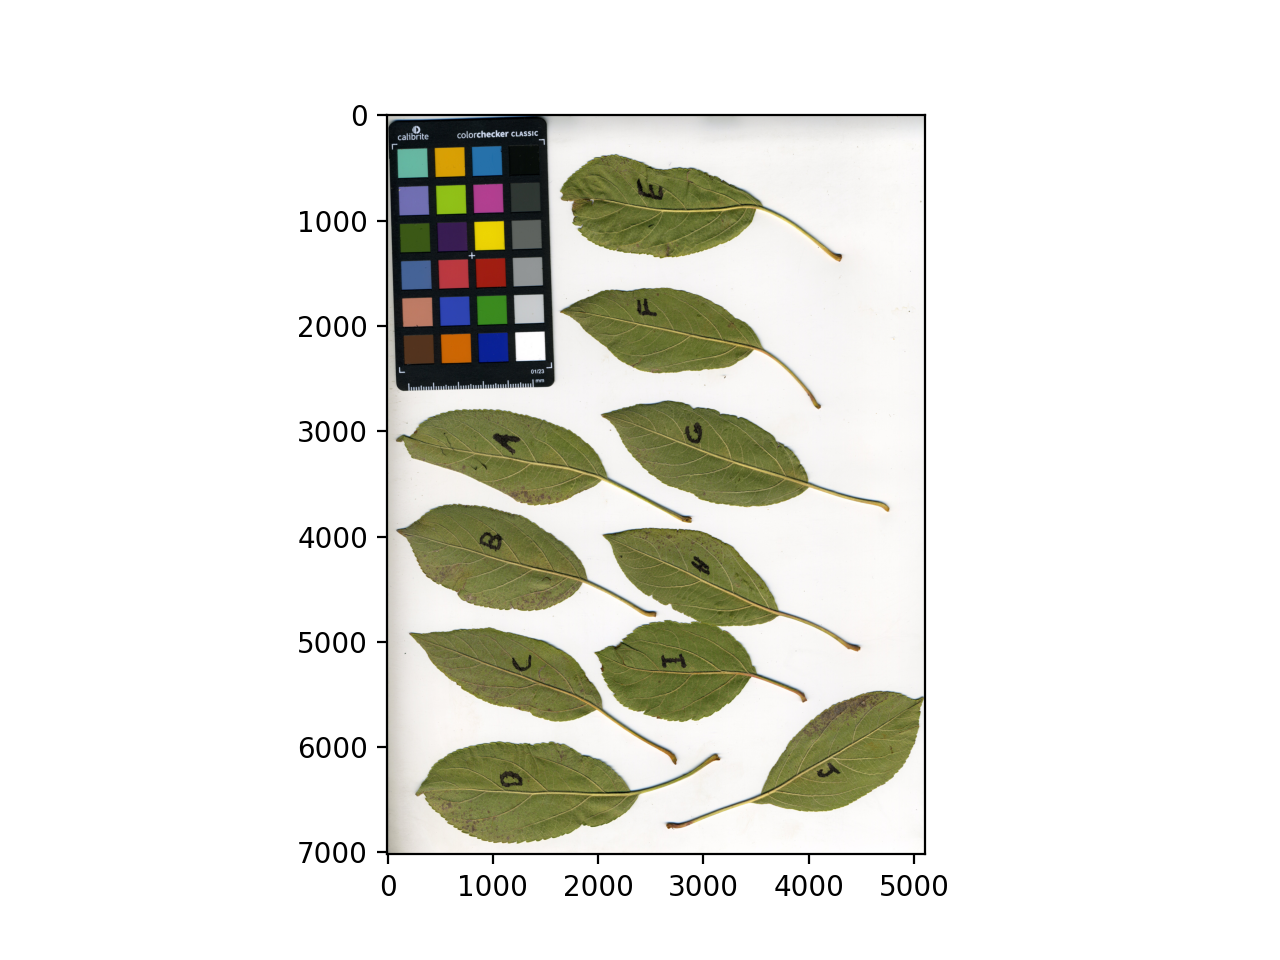

In [3]:
#im = cv.imread("/Users/quino070/AppleScans/Leaf/L_1022-53_R1_S001.jpg")
im = cv.imread("/Users/quino070/AppleScans/Leaf/L_1022-24_R1_S001.jpg")

im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
#im = cv.convertScaleAbs(im, alpha=1.5, beta=3)
# #adding border to fix leaves too close to the edge
# im = cv.copyMakeBorder(im, 100, 100, 100, 100,
#                                     cv.BORDER_CONSTANT, value=(255, 255, 255)) 
plt.figure()
plt.imshow(im)

In [4]:
# Segment using text prompt
inputs = processor(images=im, text="leaf_with_stem", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# Post-process results
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"Found {len(results['masks'])} objects")

Found 10 objects


<IPython.core.display.Javascript object>


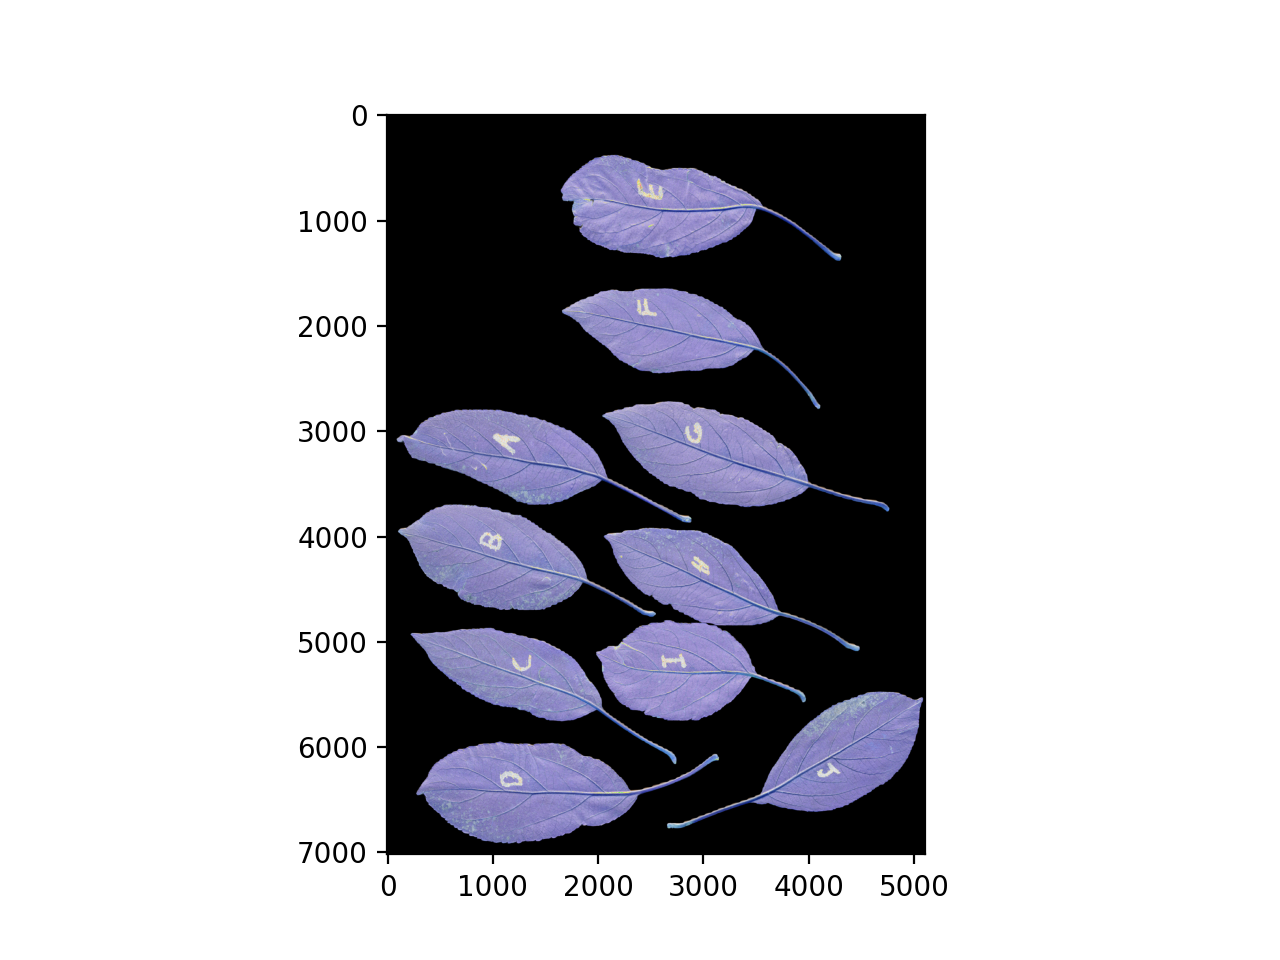

In [5]:
masks = results["masks"]  # list or tensor of shape (N, H, W)

# Stack and combine (logical OR across objects)
if isinstance(masks, list):
    masks_tensor = torch.stack(masks)
else:
    masks_tensor = masks

combined_mask = masks_tensor.any(dim=0).cpu().numpy().astype(np.uint8) * 255
    
image_np = np.array(im)
masked_im = image_np * combined_mask[..., None]

plt.figure()
plt.imshow(masked_im)

<IPython.core.display.Javascript object>


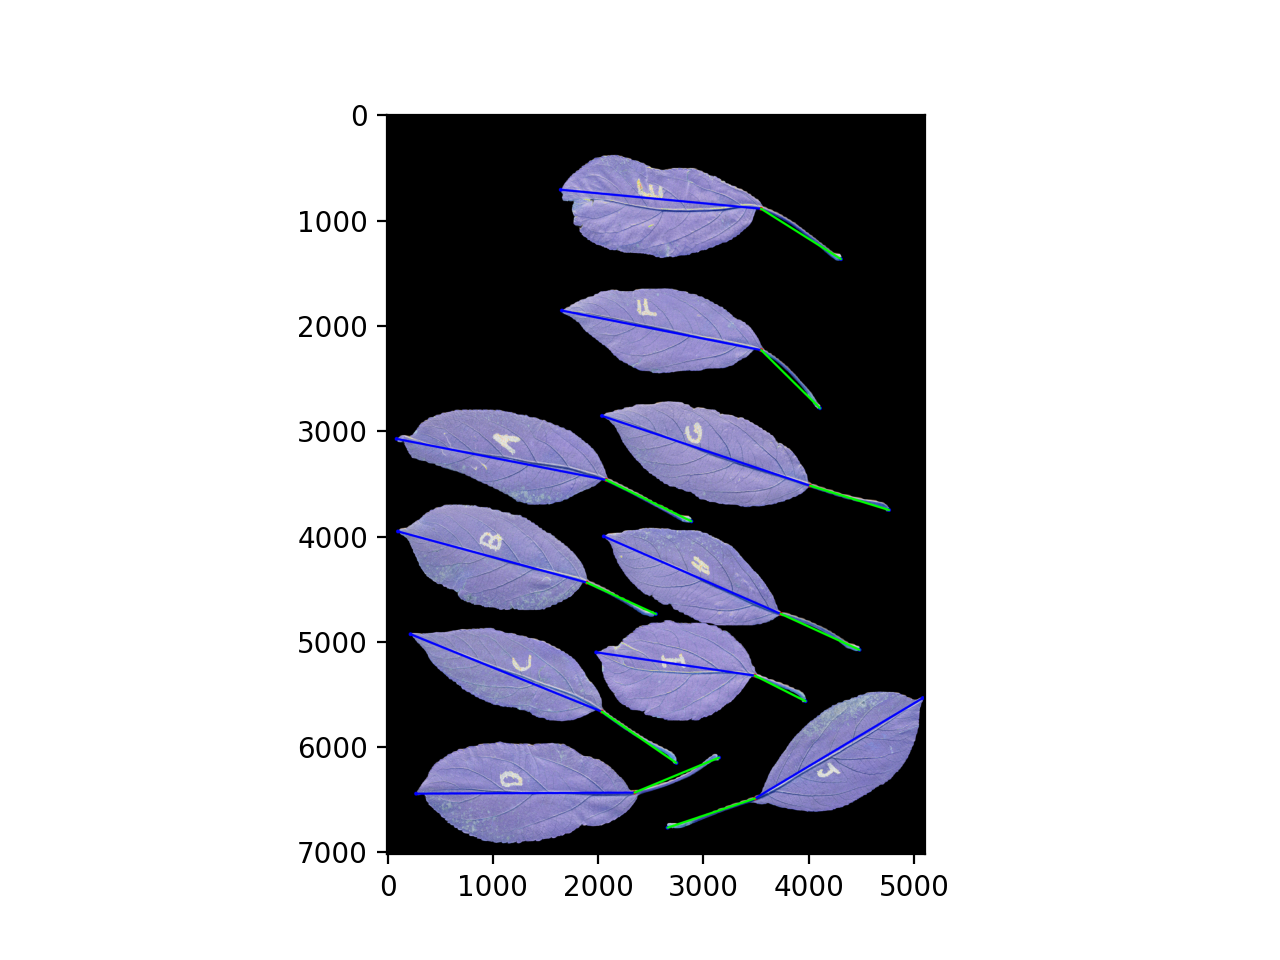

In [272]:
object_info = []
masked_image = masked_im.copy()

for idx,leaf in enumerate(results['masks']):
    leaf = np.array(leaf, np.uint8) * 255
    
    # Find right, bottom-most point to get tip of petiole
    points = cv.findNonZero(leaf).reshape(-1,2)

    #Get convex hull of whole object
    cxh = cv.convexHull(points)
    
    ####Get start of petiole:
    #First, get contour, select biggest
    contours, _ = cv.findContours(leaf, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    bigleaf = max(contours, key=cv.contourArea)

    #Find convex hull of contour, get deepest depression    
    defects = cv.convexityDefects(bigleaf, cv.convexHull(bigleaf,  returnPoints=False))
    #select the defects with the largest depth
    petiole_pt1_id = np.argsort(defects[:,0,3])[::-1][0]

    #Convert defect info into coords
    #Get difference between deepest defect and all others
    defects_xy = []

    for i in range(defects.shape[0]):
        s,e,f,d = defects[i,0]
        far = tuple(bigleaf[f][0])
        defects_xy.append(far)

    defects_xy = np.array(defects_xy)

    #Get pairwise distances between all points, subset column of deepest defect
    defect_distances = pairwise_distances(defects_xy, metric='euclidean')[:,petiole_pt1_id]
    #Subset closest non-zero defect
    p2 = defects_xy[np.argsort(defect_distances)[1]]
    #Extract pt1 coords
    p1 = defects_xy[petiole_pt1_id]
    #Now get coordinates for mid point
    (px, py) = int((p1[0] + p2[0]) / 2), int((p1[1] + p2[1]) / 2)
    
    
#     # Convert to (N, 2)
    points = cxh.reshape(-1, 2)

    # Pairwise vector differences (N, N, 2)
    diffs = points[:, None, :] - points[None, :, :]

    # Pairwise Euclidean distances (N, N)
    distances = np.linalg.norm(diffs, axis=2)

    ##Get blade tip and petiole end
    # Ignore self-distances
    np.fill_diagonal(distances, -1)

    # Index of maximum distance
    flat_idx = np.argmax(distances)
    i, j = np.unravel_index(flat_idx, distances.shape)
    

    # Results
    max_distance = distances[i, j]
    (x1,y1) = points[i]
    (x2,y2) = points[j]
    
    d1 = int(np.linalg.norm(np.array([x1,y1]) - np.array([px,py])))
    d2 = int(np.linalg.norm(np.array([x2,y2]) - np.array([px,py])))
    
    if d1 > d2:
        blade_length = d1
        petiole_length = d2
        (lx, ly) = (x1,y1)
        (sx, sy) = (x2,y2)
    else:
        blade_length = d2
        petiole_length = d1
        (lx, ly) = (x2,y2)
        (sx, sy) = (x1,y1)
    
    
    
    #Draw petiole start
    cv.circle(masked_image,(px,py),10,[255, 0, 0],15)
    cv.circle(masked_image,(x1,y1),10,[0, 0, 255],15)
    cv.circle(masked_image,(x2,y2),10,[0, 0, 255],15)

    #Height from leaf tip to petiole start
    cv.line(masked_image, (lx, ly), (px,py), (0, 0, 255), 20)

    #Height from petiole start to petiole end
    cv.line(masked_image, (px,py), (sx,sy), (0, 255, 0), 20)
    
    
    object_info.append({
        'Leaf': idx + 1,
        'blade_length': blade_length,    
        'petiole_length': petiole_length
    })
    
plt.figure()
plt.imshow(masked_image)

In [6]:
pd.DataFrame(object_info)

,Leaf,blade_length,petiole_length
0,1,1849,608
1,2,1876,664
2,3,1941,609
3,4,2467,875
4,5,2528,827
5,6,1400,585
6,7,1812,779
7,8,1962,709
8,9,1538,533
9,10,2143,781
